This notebook will quickly walk you through the new features related to scattering and aerosols.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nemesispy.common.constants import *
from nemesispy.data.helper import lowres_file_paths, cia_file_path
from nemesispy.radtran.forward_model import ForwardModel
from nemesispy.data.gcm.process_gcm import tmap, vmrmap_mod
from nemesispy.data.gcm.process_gcm import xlon,xlat,pv
from nemesispy.data.gcm.process_gcm import kevin_phase_by_wave, pat_phase_by_wave

First, let's calculate an ordinary disc spectrum.

In [2]:
# Wavelengths grid for the emission spectrum (microns)
wave_grid = np.array([1.1425, 1.1775, 1.2125, 1.2475, 1.2825, 1.3175, 1.3525,
1.3875, 1.4225, 1.4575, 1.4925, 1.5275, 1.5625, 1.5975, 1.6325, 3.6, 4.5])
nwave = len(wave_grid)
# Orbital phase grid (degree)
phase_grid = np.array([ 22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. ,
    202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5])
nphase = len(phase_grid)
# WASP-43 stellar spectrum to convert flux to Fp/Fs
wasp43_spec = np.array(
    [3.341320e+25, 3.215455e+25, 3.101460e+25, 2.987110e+25,
    2.843440e+25, 2.738320e+25, 2.679875e+25, 2.598525e+25,
    2.505735e+25, 2.452230e+25, 2.391140e+25, 2.345905e+25,
    2.283720e+25, 2.203690e+25, 2.136015e+25, 1.234010e+24,
    4.422200e+23]
    )
# Pick resolution for the disc average
nmu = 5 # Number of mu bins
# Reference planetary parameters
M_plt = 2.034 * M_JUP # kg
R_plt = 1.036 * R_JUP_E # m
# List of gas species to include in the model using identifiers
gas_id = np.array([1, 2,  5,  6, 40, 39]) # H2O, CO2, CO, CH4, H2, He
iso_id = np.array([0, 0, 0, 0, 0, 0]) # Isotopologue identifier
# Define the atmospheric model
NLAYER = 40 # Number of layers
top_pressure = 100 # Top pressure in Pa
botttom_pressure = 20e5 # Bottom pressure in Pa
P_model = np.geomspace(botttom_pressure,top_pressure,NLAYER) # Pressure grid in Pa

In [3]:
# Create a ForwardModel object
FM = ForwardModel()
FM.set_planet_model(
    M_plt=M_plt,R_plt=R_plt,
    gas_id_list=gas_id,iso_id_list=iso_id,
    NLAYER=NLAYER
    )
FM.set_opacity_data(
    kta_file_paths=lowres_file_paths,
    cia_file_path=cia_file_path
)

[0.00022886 0.00024863 0.0003056  0.0003832  0.00043493 0.0004079
 0.00026642 0.00023871 0.00023655 0.00025694 0.00029318 0.00034508
 0.00041056 0.00048727 0.0005497  0.00280154 0.00367963]
CPU times: user 20.9 s, sys: 781 ms, total: 21.6 s
Wall time: 21.8 s


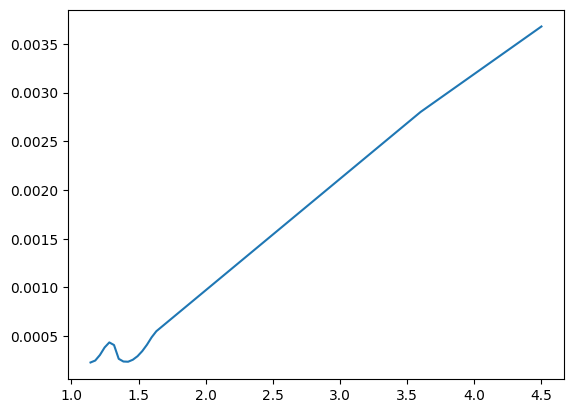

In [4]:
%%time
# Pick an orbital phase
phasenumber = 3 # secondary eclipse
phase = phase_grid[phasenumber]
one_phase =  FM.calc_disc_spectrum(phase=phase, nmu=nmu, P_model = P_model,
    global_model_P_grid=pv,
    global_T_model=tmap, global_VMR_model=vmrmap_mod,
    mod_lon=xlon,
    mod_lat=xlat,
    solspec=wasp43_spec)

 Now, let's do a run with multiple scattering. We can define a global aerosol map. For simplicity, let's define one that's constant everywhere (1e-4 particles/gram) and has 2 modes. It's the same shape as the VMR map, but with NMODES=2 instead of NVMR=6.

In [5]:
print(vmrmap_mod.shape)
amap = 1e-4 * np.ones((vmrmap_mod.shape[0],vmrmap_mod.shape[1],vmrmap_mod.shape[2],2))
print(amap.shape)


(64, 32, 53, 6)
(64, 32, 53, 2)


To use multiple scattering, we need to define some aerosol modes. Let's first get rid of any modes we might have previously defined:

In [6]:
FM.clear_phase_function()

Now we can add modes. Makephase might take a few seconds to compile.

In [7]:
FM.clear_phase_function()
# Using 20 calculation wavelengths for Makephase,
# evenly distributed over our wavelength range
NWAVE_NIMAG = 20
n_imag_wave_grid = np.linspace(FM.wave_grid.min(),FM.wave_grid.max(),NWAVE_NIMAG)

# Adding mode 1 - gamma distribution (iscat=1)
n_imag =  np.ones(NWAVE_NIMAG)*0.01

FM.add_phase_function(mean_size = 1.6, 
                      size_variance = 0.3, 
                      n_imag = n_imag, 
                      n_imag_wave_grid = n_imag_wave_grid, 
                      n_real_reference = 1.4,
                      iscat = 1)

# Adding mode 2 - constant sized particles (iscat=4)
n_imag =  np.ones(NWAVE_NIMAG)*0.001

FM.add_phase_function(mean_size = 4.0, 
                      size_variance = 0.0, 
                      n_imag = n_imag, 
                      n_imag_wave_grid = n_imag_wave_grid, 
                      n_real_reference = 1.8,
                      iscat = 4)

We can have a look at the properties of our different aerosol modes.

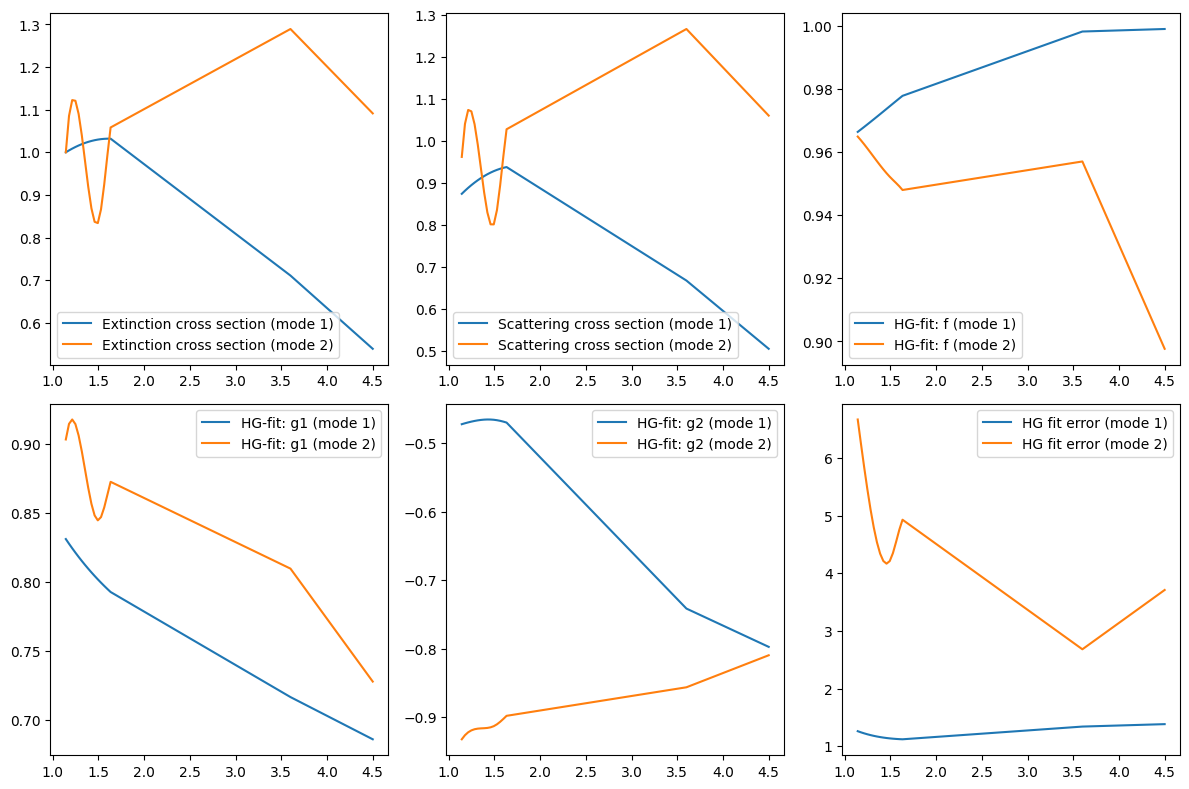

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
parameters = ['Extinction cross section','Scattering cross section',
              'HG-fit: f','HG-fit: g1','HG-fit: g2','HG fit error']
for i in range(6):
    row = i // 3
    col = i % 3
    axs[row, col].plot(FM.wave_grid, FM.phase_func[:, :, i].transpose())
    axs[row, col].legend([f'{parameters[i]} (mode 1)', f'{parameters[i]} (mode 2)'])

plt.tight_layout()
plt.show()

Now, we can calculate our spectrum using multiple scattering and our aerosol model. This might take a while - for me, it takes about 30 times as long as the non-scattering case (once it's compiled). Multiple scattering is signifiantly slower, and running at high emission angles (necessary for a disc-integrated spectrum) slows things down further, as we have to calculate more azimuthal Fourier components. As well as this, I think there are more constant-time overheads with the multiple scattering, so for small spectra like this it's extra slow in comparison.

In [9]:
%%time

phasenumber = 3 # secondary eclipse
phase = phase_grid[phasenumber]
one_phase_aerosol =  FM.calc_disc_spectrum(phase=phase, nmu=nmu, P_model = P_model,
    global_model_P_grid=pv,
    global_T_model=tmap, global_VMR_model=vmrmap_mod, global_A_model=amap,
    mod_lon=xlon,
    mod_lat=xlat,
    solspec=wasp43_spec)

/STEM/data/project/users/ab39556/runs/nemesispy_scatter/nemesispy_agni/nemesispy/radtran/calc_spectrum_scloud11.py:17: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  spectrum = scloud11wave(phasarr = phase_func,


CPU times: user 55.8 s, sys: 730 ms, total: 56.6 s
Wall time: 56.8 s


Let's compare the spectra with and without aerosol:

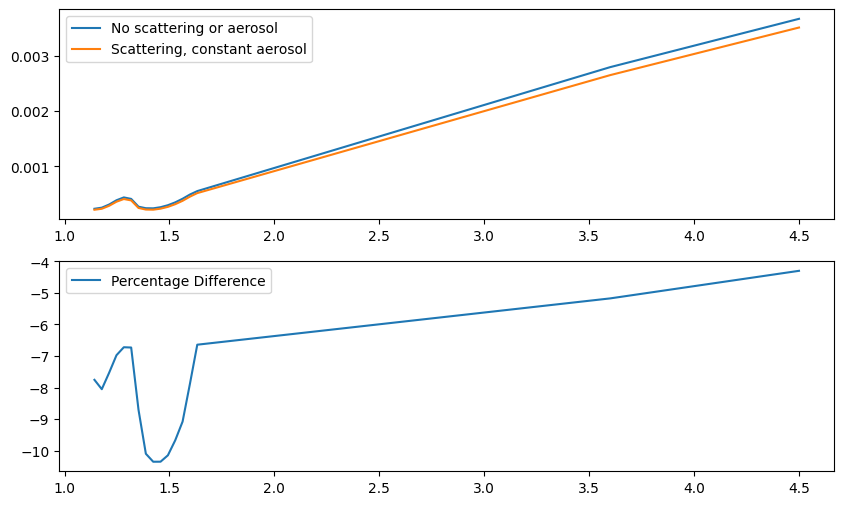

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(wave_grid, one_phase, label='No scattering or aerosol')
ax1.plot(wave_grid, one_phase_aerosol, label='Scattering, constant aerosol')
ax1.legend()
ax2.plot(wave_grid, (one_phase_aerosol - one_phase)/one_phase * 100, label='Percentage Difference')
ax2.legend()
plt.show()

We can also calculate point spectra as well as disc spectra. You can see the effect of our second aerosol mode very clearly between 1um and 1.5um in this case.

In [11]:
from time import time

# Just setting up some constant profiles for simplicity
T_model = 1000 * np.ones_like(P_model)
VMR_model = 0.1 * np.ones((P_model.shape[0],vmrmap_mod.shape[-1]))

toc = time()
point = FM.calc_point_spectrum_hydro(P_model = P_model, 
                                     T_model = T_model, 
                                     VMR_model = VMR_model, 
                                     angles=np.array([0.0,0.0,180.0]),
                                     solspec=wasp43_spec) # angles: stellar, emission, azimuth
tic = time()
print(f'Ran in {tic-toc}s')

# Constant aerosol 
A_model = 1e-1 * np.ones((P_model.shape[0],amap.shape[-1]))

toc = time()
point_aerosol = FM.calc_point_spectrum_hydro(P_model = P_model, 
                                     T_model = T_model, 
                                     VMR_model = VMR_model, 
                                     A_model = A_model,
                                     angles=np.array([0.0,0.0,180.0]),
                                     solspec=wasp43_spec) # angles: stellar, emission, azimuth
tic = time()
print(f'Scattering ran in {tic-toc}s')


Ran in 1.8666753768920898s
Scattering ran in 0.38845109939575195s


In [16]:
print(T_model.shape, VMR_model.shape, P_model.shape, A_model.shape)

(40,) (40, 6) (40,) (40, 2)


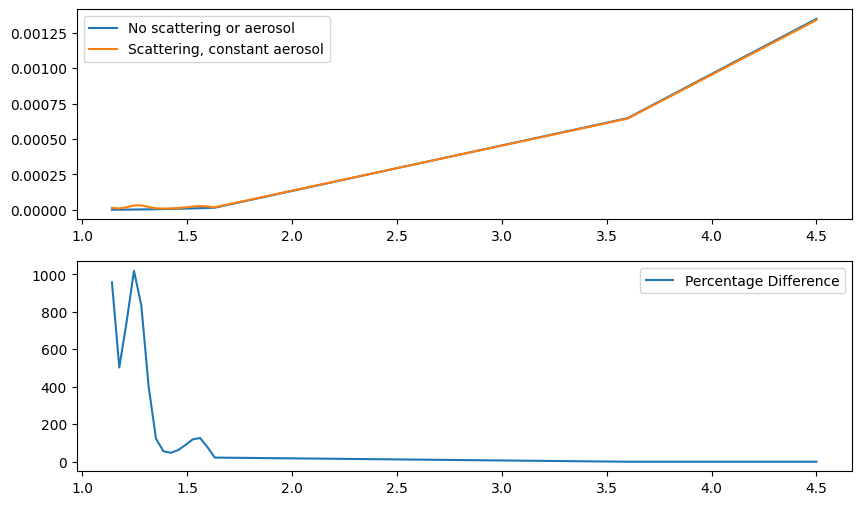

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(wave_grid, point, label='No scattering or aerosol')
ax1.plot(wave_grid, point_aerosol, label='Scattering, constant aerosol')
ax1.legend()
ax2.plot(wave_grid, (point_aerosol - point)/point * 100, label='Percentage Difference')
ax2.legend()
plt.show()